In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Embedding, Dense
from tensorflow.keras.layers import Dense, BatchNormalization

# Bayesian Methods for Hackers style sheet
plt.style.use('bmh')
np.random.seed(7)

In [6]:
# PeriodicLogger — helper logger class at the end of each epoch

class PeriodicLogger(Callback):
    """
    A helper callback class that only prints the losses once in 'display' epochs
    """    
    def __init__(self, display=100):
        self.display = display
    def on_train_begin(self, logs={}):
        self.epochs = 0
    def on_epoch_end(self, batch, logs={}):
        self.epochs += 1
        if self.epochs % self.display == 0:
            print("Epoch: %d - loss: %f - val_loss: %f" % (self.epochs, logs['loss'], logs['val_loss']))

periodic_logger_250 = PeriodicLogger(250)

In [7]:
# Define the mapping and a function that computes the house price for each example

per_meter_mapping = {    
    'Mercaz': 500,
    'Old North': 350,
    'Florentine': 230
    }

per_room_additional_price = {    
    'Mercaz': 15. * 10 ** 4,
    'Old North': 8. * 10 ** 4,
    'Florentine': 5. * 10 ** 4
    }

def house_price_func(row):    
    """
    house_price_func is the function f(a,s,n).    
    :param row: dict (contains the keys: ['area', 'size', 'n_rooms'])
    :return: float
    """
    area, size, n_rooms = row['area'], row['size'], row['n_rooms']
    return size * per_meter_mapping[area] + n_rooms * per_room_additional_price[area]

In [8]:
# Create toy data

AREAS = ['Mercaz', 'Old North', 'Florentine']
def create_samples(n_samples): 
    """
    Helper method that creates dataset DataFrames
    Note that the np.random.choice call only determines the number of rooms and the size of the house
    (the price, which we calculate later, is deterministic)
    
    :param n_samples: int (number of samples for each area (suburb))
    :return: pd.DataFrame
    """
    
    samples = []

    for n_rooms in np.random.choice(range(1, 6), n_samples):
            samples += [(area, int(np.random.normal(25, 5)), n_rooms) for area in AREAS]

    return pd.DataFrame(samples, columns=['area', 'size', 'n_rooms'])

In [9]:
# Create the train and validation sets
train = create_samples(n_samples=1000)
val = create_samples(n_samples=100)

In [11]:
# Calculate the prices for each set
train['price'] = train.apply(house_price_func, axis=1)
val['price'] = val.apply(house_price_func, axis=1)

In [12]:
train.head()

,area,size,n_rooms,price
0,Mercaz,20,5,760000.0
1,Old North,28,5,409800.0
2,Florentine,31,5,257130.0
3,Mercaz,22,2,311000.0
4,Old North,22,2,167700.0


In [16]:
# Define the features and the Y vectors
# We will separate the continuous and categorical variables
continuous_cols = ['size', 'n_rooms']
categorical_cols = ['area']
y_col = ['price']

X_train_continuous = train[continuous_cols]
X_train_categorical = train[categorical_cols]
y_train = train[y_col]

X_val_continuous = val[continuous_cols]
X_val_categorical = val[categorical_cols]
y_val = val[y_col]

In [17]:
# Normalizing both train and test sets to have 0 mean and std. of 1 using the train set mean and std.
# This will give each feature an equal initial importance and speed up the training time
train_mean = X_train_continuous.mean(axis=0)
train_std = X_train_continuous.std(axis=0)

X_train_continuous = X_train_continuous - train_mean
X_train_continuous /= train_std

X_val_continuous = X_val_continuous - train_mean
X_val_continuous /= train_std

In [19]:
# Build a model using a categorical variable
# First, let’s define a helper class for the categorical variable

class EmbeddingMapping():
    """
    Helper class for handling categorical variables
    An instance of this class should be defined for each categorical variable we want to use.
    """
    
    def __init__(self, series):
        # get a list of unique values
        values = series.unique().tolist()
        # Set a dictionary mapping from values to integer value
        # In our example this will be {'Mercaz': 1, 'Old North': 2, 'Florentine': 3}
        self.embedding_dict = {value: int_value + 1 for int_value, value in enumerate(values)}
        # The num_values will be used as the input_dim when defining the embedding layer. 
        # It will also be returned for unseen values 
        self.num_values = len(values) + 1

    def get_mapping(self, value):
        # If the value was seen in the training set, return its integer mapping
        if value in self.embedding_dict:
            return self.embedding_dict[value]
        # Else, return the same integer for unseen values
        else:
            return self.num_values

In [20]:
# Create an embedding column for the train/validation sets
area_mapping = EmbeddingMapping(X_train_categorical['area'])
X_train_categorical = X_train_categorical.assign(area_mapping=X_train_categorical[
'area'].apply(area_mapping.get_mapping))
X_val_categorical = X_val_categorical.assign(area_mapping=X_val_categorical[
'area'].apply(area_mapping.get_mapping))

In [21]:
X_train_categorical.head()

,area,area_mapping
0,Mercaz,1
1,Old North,2
2,Florentine,3
3,Mercaz,1
4,Old North,2


In [22]:
# Define the input layers
# Define the embedding input
area_input = Input(shape=(1,), dtype='int32') 
# Decide to what vector size we want to map our 'area' variable. 
# I'll use 1 here because we only have three areas
embeddings_output = 1
# Let’s define the embedding layer and flatten it
area_embedings = Embedding(output_dim=embeddings_output, input_dim=area_mapping.num_values, input_length=1)(area_input)
area_embedings = keras.layers.Reshape((embeddings_output,))(area_embedings)
# Define the continuous variables input (just like before)
continuous_input = Input(shape=(X_train_continuous.shape[1], ))
# Concatenate continuous and embeddings inputs
all_input = keras.layers.concatenate([continuous_input, area_embedings])

W0708 16:19:55.269750 4602951104 deprecation.py:506] From /Users/zeevkalyuzhner/.virtualenvs/effort-estimation/lib/python3.7/site-packages/tensorflow/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [23]:
# We’ll define a simple model with 2 hidden layers, with 25 neurons each.
# Define the model

units=25
dense1 = Dense(units=units, activation='relu')(all_input)
dense2 = Dense(units, activation='relu')(dense1)
predictions = Dense(1)(dense2)
# Note using the input object 'area_input' not 'area_embeddings'
model = Model(inputs=[continuous_input, area_input], outputs=predictions)

W0708 16:20:15.353287 4602951104 deprecation.py:506] From /Users/zeevkalyuzhner/.virtualenvs/effort-estimation/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [27]:
epochs = 10000
model.compile(loss=
'mse', optimizer=keras.optimizers.Adam(lr=.8, beta_1=0.9, beta_2=0.999, decay=1e-03, amsgrad=True))

# Note continuous and categorical columns are inserted in the same order as defined in all_inputs
history = model.fit([X_train_continuous, X_train_categorical['area_mapping']], y_train, 
          epochs=epochs, batch_size=128, 
          callbacks=[periodic_logger_250], verbose=1,
          validation_data=([X_val_continuous, X_val_categorical[
'area_mapping']], y_val))

Train on 3000 samples, validate on 300 samples
Epoch 1/10000
3000/3000 [==============================] - 0s 114us/sample - loss: 3831507040.0759 - val_loss: 656359428.6933
Epoch 2/10000
3000/3000 [==============================] - 0s 13us/sample - loss: 455957416.2347 - val_loss: 116453553.9200
Epoch 3/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 48774222.9573 - val_loss: 14420662.8000
Epoch 4/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 8418490.6793 - val_loss: 4755843.9533
Epoch 5/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 3586433.3020 - val_loss: 2229914.7733
Epoch 6/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 1879214.5253 - val_loss: 1418773.0000
Epoch 7/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 1198111.7720 - val_loss: 809568.4650
Epoch 8/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 740914.7298 - val_lo

Epoch 71/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 2522.6843 - val_loss: 2574.9363
Epoch 72/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 2505.3180 - val_loss: 2743.2748
Epoch 73/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 2361.4986 - val_loss: 2606.0480
Epoch 74/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 2297.6411 - val_loss: 2452.0170
Epoch 75/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 2322.6370 - val_loss: 2466.9068
Epoch 76/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 2159.3511 - val_loss: 2340.0644
Epoch 77/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 2145.2463 - val_loss: 2358.0988
Epoch 78/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 2078.5930 - val_loss: 2255.7773
Epoch 79/10000
3000/3000 [==============================] - 0s 10us/sample - los

Epoch 142/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 1221.1887 - val_loss: 1534.9140
Epoch 143/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 1210.6503 - val_loss: 1418.9086
Epoch 144/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 1230.3397 - val_loss: 1426.4258
Epoch 145/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 1161.1461 - val_loss: 1433.2432
Epoch 146/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 1173.8786 - val_loss: 1387.2926
Epoch 147/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 1157.1018 - val_loss: 1400.6266
Epoch 148/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 1154.6934 - val_loss: 1553.9078
Epoch 149/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 1282.5107 - val_loss: 1409.5396
Epoch 150/10000
3000/3000 [==============================] - 0s 10us/sam

3000/3000 [==============================] - 0s 10us/sample - loss: 947.4325 - val_loss: 1158.4493
Epoch 213/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 935.1675 - val_loss: 1136.5831
Epoch 214/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 927.4439 - val_loss: 1153.9353
Epoch 215/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 935.9233 - val_loss: 1130.8507
Epoch 216/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 957.7342 - val_loss: 1127.5571
Epoch 217/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 936.0929 - val_loss: 1144.0504
Epoch 218/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 909.6645 - val_loss: 1119.9959
Epoch 219/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 954.6217 - val_loss: 1245.7579
Epoch 220/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 954.7784 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 816.4047 - val_loss: 999.6785
Epoch 283/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 830.8860 - val_loss: 992.4271
Epoch 284/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 817.7073 - val_loss: 984.1354
Epoch 285/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 831.1881 - val_loss: 1007.5474
Epoch 286/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 808.1622 - val_loss: 974.8644
Epoch 287/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 807.9847 - val_loss: 974.9726
Epoch 288/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 804.3333 - val_loss: 1009.9022
Epoch 289/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 835.8400 - val_loss: 1018.6417
Epoch 290/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 820.2727 - val_lo

Epoch 354/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 759.3745 - val_loss: 903.4051
Epoch 355/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 751.8196 - val_loss: 922.9983
Epoch 356/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 750.3511 - val_loss: 957.7414
Epoch 357/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 764.0346 - val_loss: 920.9848
Epoch 358/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 774.5141 - val_loss: 924.1249
Epoch 359/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 762.7437 - val_loss: 921.6947
Epoch 360/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 752.9278 - val_loss: 927.5127
Epoch 361/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 753.1972 - val_loss: 915.5567
Epoch 362/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 745.

Epoch 426/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 702.4001 - val_loss: 916.6919
Epoch 427/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 724.4654 - val_loss: 854.8848
Epoch 428/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 712.7288 - val_loss: 850.8678
Epoch 429/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 720.2761 - val_loss: 864.1673
Epoch 430/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 707.9918 - val_loss: 854.6788
Epoch 431/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 709.1463 - val_loss: 861.7253
Epoch 432/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 706.3817 - val_loss: 859.5563
Epoch 433/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 724.1122 - val_loss: 893.4304
Epoch 434/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 706.

Epoch 498/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 696.2181 - val_loss: 876.2269
Epoch 499/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 689.8017 - val_loss: 804.3363
Epoch 500/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 681.8411 - val_loss: 822.4476
Epoch 501/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 677.5587 - val_loss: 808.7517
Epoch 502/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 679.7731 - val_loss: 810.3540
Epoch 503/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 676.7172 - val_loss: 808.1456
Epoch 504/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 677.5800 - val_loss: 808.1060
Epoch 505/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 675.9723 - val_loss: 830.4959
Epoch 506/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 682.

Epoch 569/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 665.0148 - val_loss: 786.4942
Epoch 570/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 657.0275 - val_loss: 790.0629
Epoch 571/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 662.8087 - val_loss: 781.4484
Epoch 572/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 667.7343 - val_loss: 780.7538
Epoch 573/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 665.7292 - val_loss: 795.3148
Epoch 574/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 664.0973 - val_loss: 783.2572
Epoch 575/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 655.0657 - val_loss: 775.1507
Epoch 576/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 659.6451 - val_loss: 803.6210
Epoch 577/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 657.

Epoch 641/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 637.4696 - val_loss: 761.0838
Epoch 642/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 640.8668 - val_loss: 760.1253
Epoch 643/10000
3000/3000 [==============================] - 0s 13us/sample - loss: 648.3694 - val_loss: 771.0679
Epoch 644/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 638.7521 - val_loss: 766.7007
Epoch 645/10000
3000/3000 [==============================] - 0s 14us/sample - loss: 635.5671 - val_loss: 751.3173
Epoch 646/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 640.0476 - val_loss: 754.3145
Epoch 647/10000
3000/3000 [==============================] - 0s 14us/sample - loss: 633.9855 - val_loss: 753.5900
Epoch 648/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 644.4319 - val_loss: 775.1595
Epoch 649/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 645.

Epoch 713/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 632.9599 - val_loss: 750.9394
Epoch 714/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 631.6194 - val_loss: 745.6483
Epoch 715/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 620.5290 - val_loss: 745.4014
Epoch 716/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 623.8687 - val_loss: 748.5949
Epoch 717/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 624.0904 - val_loss: 743.3701
Epoch 718/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 619.9231 - val_loss: 760.5137
Epoch 719/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 633.7044 - val_loss: 752.5964
Epoch 720/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 622.4823 - val_loss: 731.5017
Epoch 721/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 636.

Epoch 784/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 612.8486 - val_loss: 727.2642
Epoch 785/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 612.8325 - val_loss: 731.0340
Epoch 786/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 614.5857 - val_loss: 728.4842
Epoch 787/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 609.7609 - val_loss: 727.2920
Epoch 788/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 613.2579 - val_loss: 726.2125
Epoch 789/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 613.1851 - val_loss: 728.1683
Epoch 790/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 614.7171 - val_loss: 725.3654
Epoch 791/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 610.0393 - val_loss: 718.8694
Epoch 792/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 613.

Epoch 856/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 598.7361 - val_loss: 707.6242
Epoch 857/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 601.0454 - val_loss: 714.7150
Epoch 858/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 603.6320 - val_loss: 707.5677
Epoch 859/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 597.4687 - val_loss: 709.9163
Epoch 860/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 604.4197 - val_loss: 711.0475
Epoch 861/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 597.7833 - val_loss: 713.4670
Epoch 862/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 599.0798 - val_loss: 724.0584
Epoch 863/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 602.7726 - val_loss: 712.8157
Epoch 864/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 599.

Epoch 928/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 590.2503 - val_loss: 699.9388
Epoch 929/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 594.0766 - val_loss: 701.1169
Epoch 930/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 593.0179 - val_loss: 698.9574
Epoch 931/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 593.1797 - val_loss: 704.7691
Epoch 932/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 591.9232 - val_loss: 697.6724
Epoch 933/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 589.4326 - val_loss: 708.8771
Epoch 934/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 595.0168 - val_loss: 698.4808
Epoch 935/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 589.0323 - val_loss: 700.0618
Epoch 936/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 593.

Epoch 1000/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 588.7046 - val_loss: 689.3751
Epoch 1001/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 584.5789 - val_loss: 695.0661
Epoch 1002/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 582.6321 - val_loss: 691.3724
Epoch 1003/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 587.3496 - val_loss: 690.4989
Epoch 1004/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 583.8842 - val_loss: 692.5926
Epoch 1005/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 590.5301 - val_loss: 697.1402
Epoch 1006/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 593.7893 - val_loss: 695.5481
Epoch 1007/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 584.3724 - val_loss: 690.1779
Epoch 1008/10000
3000/3000 [==============================] - 0s 10us/sample - l

3000/3000 [==============================] - 0s 10us/sample - loss: 577.8087 - val_loss: 680.2622
Epoch 1071/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 575.8275 - val_loss: 680.5427
Epoch 1072/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 580.4556 - val_loss: 684.3561
Epoch 1073/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 581.6911 - val_loss: 679.3997
Epoch 1074/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 576.1038 - val_loss: 682.4652
Epoch 1075/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 578.6024 - val_loss: 685.8203
Epoch 1076/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 578.0068 - val_loss: 681.6432
Epoch 1077/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 577.2418 - val_loss: 683.8303
Epoch 1078/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 575.6577 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 572.0969 - val_loss: 678.8950
Epoch 1142/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 572.1477 - val_loss: 682.2874
Epoch 1143/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 577.1124 - val_loss: 675.7085
Epoch 1144/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 572.7871 - val_loss: 684.9304
Epoch 1145/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 577.9994 - val_loss: 675.0278
Epoch 1146/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 574.4690 - val_loss: 678.0703
Epoch 1147/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 575.9778 - val_loss: 672.3584
Epoch 1148/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 572.5667 - val_loss: 673.7302
Epoch 1149/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 572.4651 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 565.9490 - val_loss: 670.5427
Epoch 1213/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 566.1170 - val_loss: 670.7301
Epoch 1214/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 569.8483 - val_loss: 672.9619
Epoch 1215/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 566.2806 - val_loss: 670.5845
Epoch 1216/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 569.1202 - val_loss: 667.3072
Epoch 1217/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 564.6259 - val_loss: 665.9667
Epoch 1218/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 568.9536 - val_loss: 674.2308
Epoch 1219/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 569.9952 - val_loss: 675.0853
Epoch 1220/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 572.6307 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 564.0794 - val_loss: 671.6956
Epoch 1283/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 566.5829 - val_loss: 668.4692
Epoch 1284/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 563.6549 - val_loss: 662.2376
Epoch 1285/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 562.5378 - val_loss: 665.5111
Epoch 1286/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 559.4931 - val_loss: 666.9965
Epoch 1287/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 563.3447 - val_loss: 665.0187
Epoch 1288/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 561.9161 - val_loss: 664.8938
Epoch 1289/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 563.7242 - val_loss: 661.0826
Epoch 1290/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 561.7050 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 557.2079 - val_loss: 657.6991
Epoch 1354/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 557.8169 - val_loss: 660.6384
Epoch 1355/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 560.7252 - val_loss: 659.1030
Epoch 1356/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 556.4817 - val_loss: 660.8655
Epoch 1357/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 558.4404 - val_loss: 658.0191
Epoch 1358/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 559.8262 - val_loss: 663.6859
Epoch 1359/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 559.4685 - val_loss: 656.8329
Epoch 1360/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 558.8617 - val_loss: 655.0635
Epoch 1361/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 558.3215 - v

3000/3000 [==============================] - 0s 11us/sample - loss: 555.5205 - val_loss: 656.6623
Epoch 1425/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 554.1455 - val_loss: 654.7745
Epoch 1426/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 553.4144 - val_loss: 656.5395
Epoch 1427/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 554.1830 - val_loss: 656.3901
Epoch 1428/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 555.2491 - val_loss: 660.6302
Epoch 1429/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 556.0931 - val_loss: 654.9088
Epoch 1430/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 554.9798 - val_loss: 654.6182
Epoch 1431/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 555.7856 - val_loss: 659.3481
Epoch 1432/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 555.7146 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 549.8625 - val_loss: 654.2145
Epoch 1496/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 550.6748 - val_loss: 653.5049
Epoch 1497/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 552.6449 - val_loss: 652.7921
Epoch 1498/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 550.7416 - val_loss: 653.3192
Epoch 1499/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 550.4566 - val_loss: 648.2534
Epoch 1500/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 554.7593 - val_loss: 647.5548
Epoch 1501/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 550.5217 - val_loss: 650.4552
Epoch 1502/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 555.0670 - val_loss: 655.5212
Epoch 1503/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 555.5987 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 546.9451 - val_loss: 644.8670
Epoch 1566/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 546.5623 - val_loss: 646.7381
Epoch 1567/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 545.9899 - val_loss: 645.4391
Epoch 1568/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 546.8788 - val_loss: 647.3783
Epoch 1569/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 546.0311 - val_loss: 649.5053
Epoch 1570/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 547.8339 - val_loss: 655.7866
Epoch 1571/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 551.1787 - val_loss: 649.3971
Epoch 1572/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 548.4408 - val_loss: 647.1717
Epoch 1573/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 547.9965 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 544.9531 - val_loss: 643.3329
Epoch 1637/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 546.7875 - val_loss: 643.3064
Epoch 1638/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 546.0800 - val_loss: 642.9604
Epoch 1639/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 547.1001 - val_loss: 641.7664
Epoch 1640/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 543.7347 - val_loss: 644.6569
Epoch 1641/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 544.0880 - val_loss: 641.9109
Epoch 1642/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 546.6972 - val_loss: 651.1476
Epoch 1643/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 544.8455 - val_loss: 644.6430
Epoch 1644/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 545.6103 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 544.2182 - val_loss: 641.8119
Epoch 1708/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 545.0191 - val_loss: 641.1418
Epoch 1709/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 540.7622 - val_loss: 639.0476
Epoch 1710/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 540.7404 - val_loss: 640.1679
Epoch 1711/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 541.3779 - val_loss: 644.5531
Epoch 1712/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 542.7534 - val_loss: 645.6107
Epoch 1713/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 541.0096 - val_loss: 640.7770
Epoch 1714/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 542.1033 - val_loss: 642.8265
Epoch 1715/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 543.1464 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 536.4337 - val_loss: 636.8931
Epoch 1778/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 537.3174 - val_loss: 636.6798
Epoch 1779/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 539.3481 - val_loss: 638.0270
Epoch 1780/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 539.5933 - val_loss: 636.9551
Epoch 1781/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 543.5750 - val_loss: 635.8272
Epoch 1782/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 542.4592 - val_loss: 637.8280
Epoch 1783/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 539.8541 - val_loss: 637.0259
Epoch 1784/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 541.3590 - val_loss: 639.8009
Epoch 1785/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 537.5733 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 537.0110 - val_loss: 634.5707
Epoch 1849/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 539.7924 - val_loss: 631.9316
Epoch 1850/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 536.4859 - val_loss: 632.0991
Epoch 1851/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 536.8040 - val_loss: 636.3799
Epoch 1852/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 535.3839 - val_loss: 635.0420
Epoch 1853/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 537.3621 - val_loss: 633.8111
Epoch 1854/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 536.9202 - val_loss: 636.0949
Epoch 1855/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 538.1043 - val_loss: 630.6918
Epoch 1856/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 537.0614 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 535.5981 - val_loss: 633.3865
Epoch 1920/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 534.5661 - val_loss: 632.9751
Epoch 1921/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 536.5229 - val_loss: 637.0675
Epoch 1922/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 533.5409 - val_loss: 630.9274
Epoch 1923/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 533.7626 - val_loss: 631.4185
Epoch 1924/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 535.9786 - val_loss: 633.9316
Epoch 1925/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 535.7160 - val_loss: 637.1574
Epoch 1926/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 533.7056 - val_loss: 632.4175
Epoch 1927/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 532.8095 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 531.3781 - val_loss: 628.9542
Epoch 1991/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 532.4289 - val_loss: 629.8471
Epoch 1992/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 533.4652 - val_loss: 631.3977
Epoch 1993/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 532.0168 - val_loss: 628.5307
Epoch 1994/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 531.8029 - val_loss: 634.2742
Epoch 1995/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 537.2910 - val_loss: 631.0152
Epoch 1996/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 530.9344 - val_loss: 630.6638
Epoch 1997/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 532.4460 - val_loss: 632.2435
Epoch 1998/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 530.3527 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 529.8727 - val_loss: 627.4989
Epoch 2061/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 532.6193 - val_loss: 628.3508
Epoch 2062/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 529.6408 - val_loss: 627.9461
Epoch 2063/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 529.4769 - val_loss: 630.5075
Epoch 2064/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 531.7994 - val_loss: 627.0001
Epoch 2065/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 528.7503 - val_loss: 626.5573
Epoch 2066/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 529.7434 - val_loss: 629.8028
Epoch 2067/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 529.2119 - val_loss: 627.1163
Epoch 2068/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 530.1276 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 529.9534 - val_loss: 627.1443
Epoch 2132/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 531.0526 - val_loss: 628.1346
Epoch 2133/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 531.1026 - val_loss: 628.0633
Epoch 2134/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 526.9790 - val_loss: 625.6465
Epoch 2135/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 528.0696 - val_loss: 623.0324
Epoch 2136/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 527.6218 - val_loss: 625.4446
Epoch 2137/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 530.2406 - val_loss: 625.0894
Epoch 2138/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 527.3395 - val_loss: 624.2824
Epoch 2139/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 526.3507 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 525.2640 - val_loss: 624.9600
Epoch 2203/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 524.5480 - val_loss: 622.3020
Epoch 2204/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 525.6889 - val_loss: 624.1124
Epoch 2205/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 525.1096 - val_loss: 622.8382
Epoch 2206/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 525.0042 - val_loss: 623.9668
Epoch 2207/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 524.9295 - val_loss: 623.1302
Epoch 2208/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 526.0450 - val_loss: 622.8288
Epoch 2209/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 526.4957 - val_loss: 624.7954
Epoch 2210/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 527.2415 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 524.1958 - val_loss: 622.4027
Epoch 2273/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 526.9828 - val_loss: 625.0462
Epoch 2274/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 525.5177 - val_loss: 622.5989
Epoch 2275/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 524.9123 - val_loss: 622.4670
Epoch 2276/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 524.2359 - val_loss: 620.9491
Epoch 2277/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 524.1658 - val_loss: 622.9509
Epoch 2278/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 523.8673 - val_loss: 622.8356
Epoch 2279/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 527.0541 - val_loss: 619.8810
Epoch 2280/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 525.5235 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 522.0149 - val_loss: 620.7644
Epoch 2344/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 522.4799 - val_loss: 621.7620
Epoch 2345/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 521.1527 - val_loss: 618.1585
Epoch 2346/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 521.7788 - val_loss: 620.7031
Epoch 2347/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 521.7390 - val_loss: 620.5654
Epoch 2348/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 523.1620 - val_loss: 619.2707
Epoch 2349/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 522.2301 - val_loss: 618.9542
Epoch 2350/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 522.8692 - val_loss: 621.1524
Epoch 2351/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 521.8999 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 521.0387 - val_loss: 618.8078
Epoch 2415/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 519.8937 - val_loss: 619.4339
Epoch 2416/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 521.6012 - val_loss: 617.5022
Epoch 2417/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 519.9416 - val_loss: 616.4350
Epoch 2418/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 520.0910 - val_loss: 617.6777
Epoch 2419/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 519.7533 - val_loss: 617.4313
Epoch 2420/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 520.8642 - val_loss: 617.8964
Epoch 2421/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 520.2576 - val_loss: 616.7640
Epoch 2422/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 520.4948 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 520.0150 - val_loss: 617.6287
Epoch 2486/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 520.7542 - val_loss: 615.1698
Epoch 2487/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 518.8638 - val_loss: 617.5632
Epoch 2488/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 519.5438 - val_loss: 615.9318
Epoch 2489/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 518.9967 - val_loss: 616.6330
Epoch 2490/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 520.4467 - val_loss: 617.4551
Epoch 2491/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 523.8984 - val_loss: 615.3873
Epoch 2492/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 521.5095 - val_loss: 617.2267
Epoch 2493/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 519.1845 - v

3000/3000 [==============================] - 0s 11us/sample - loss: 518.6218 - val_loss: 615.2509
Epoch 2556/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 518.2622 - val_loss: 614.3029
Epoch 2557/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 520.5449 - val_loss: 617.7318
Epoch 2558/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 518.6121 - val_loss: 615.1121
Epoch 2559/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 520.3899 - val_loss: 615.7633
Epoch 2560/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 522.5249 - val_loss: 616.6438
Epoch 2561/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 517.6724 - val_loss: 616.3797
Epoch 2562/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 519.2663 - val_loss: 616.6705
Epoch 2563/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 520.6749 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 518.6541 - val_loss: 615.5657
Epoch 2627/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 516.9234 - val_loss: 611.7622
Epoch 2628/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 516.9822 - val_loss: 614.7467
Epoch 2629/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 517.8887 - val_loss: 612.3971
Epoch 2630/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 516.7593 - val_loss: 613.6354
Epoch 2631/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 516.5691 - val_loss: 614.1601
Epoch 2632/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 516.2550 - val_loss: 613.4304
Epoch 2633/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 517.0741 - val_loss: 613.3947
Epoch 2634/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 516.0756 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 516.8386 - val_loss: 613.1328
Epoch 2698/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 516.3807 - val_loss: 610.8602
Epoch 2699/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 516.1364 - val_loss: 614.7689
Epoch 2700/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 518.8801 - val_loss: 610.3262
Epoch 2701/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 518.5830 - val_loss: 614.1880
Epoch 2702/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 516.8865 - val_loss: 611.7847
Epoch 2703/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 517.6361 - val_loss: 614.2449
Epoch 2704/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 517.8850 - val_loss: 612.9056
Epoch 2705/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 516.6632 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 516.0150 - val_loss: 612.4400
Epoch 2768/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 515.3660 - val_loss: 611.0929
Epoch 2769/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 515.3944 - val_loss: 610.0539
Epoch 2770/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 514.7379 - val_loss: 611.8734
Epoch 2771/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 514.1879 - val_loss: 611.2547
Epoch 2772/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 513.9153 - val_loss: 610.0747
Epoch 2773/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 516.0332 - val_loss: 608.8258
Epoch 2774/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 515.5710 - val_loss: 609.6963
Epoch 2775/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 514.7646 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 513.7524 - val_loss: 611.2861
Epoch 2839/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 512.1819 - val_loss: 610.8057
Epoch 2840/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 514.0634 - val_loss: 610.8157
Epoch 2841/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 513.5651 - val_loss: 610.9045
Epoch 2842/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 511.3864 - val_loss: 611.9920
Epoch 2843/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 512.5572 - val_loss: 611.3487
Epoch 2844/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 512.3820 - val_loss: 612.4975
Epoch 2845/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 513.4988 - val_loss: 613.5558
Epoch 2846/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 513.8995 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 510.7669 - val_loss: 610.4903
Epoch 2910/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 510.8435 - val_loss: 610.3969
Epoch 2911/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 510.4023 - val_loss: 609.8342
Epoch 2912/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 509.7792 - val_loss: 609.8303
Epoch 2913/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 509.1631 - val_loss: 610.3210
Epoch 2914/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 510.9087 - val_loss: 610.7692
Epoch 2915/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 510.0545 - val_loss: 609.5692
Epoch 2916/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 510.2245 - val_loss: 609.0547
Epoch 2917/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 513.6610 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 508.6891 - val_loss: 608.1039
Epoch 2981/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 508.1911 - val_loss: 609.1488
Epoch 2982/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 508.3465 - val_loss: 608.2817
Epoch 2983/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 508.4235 - val_loss: 610.1281
Epoch 2984/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 509.3608 - val_loss: 609.7317
Epoch 2985/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 508.5768 - val_loss: 607.6831
Epoch 2986/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 508.0651 - val_loss: 608.4847
Epoch 2987/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 508.6561 - val_loss: 609.4304
Epoch 2988/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 509.4551 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 506.4451 - val_loss: 608.4850
Epoch 3051/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 506.8280 - val_loss: 608.7185
Epoch 3052/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 507.2954 - val_loss: 608.2174
Epoch 3053/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 507.7420 - val_loss: 608.8135
Epoch 3054/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 508.3234 - val_loss: 607.2370
Epoch 3055/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 506.9648 - val_loss: 608.2127
Epoch 3056/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 506.6021 - val_loss: 608.1510
Epoch 3057/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 506.5876 - val_loss: 609.4934
Epoch 3058/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 505.8949 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 506.6159 - val_loss: 607.9776
Epoch 3122/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 505.5483 - val_loss: 607.1843
Epoch 3123/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 506.3695 - val_loss: 606.2677
Epoch 3124/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 506.6959 - val_loss: 609.3283
Epoch 3125/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 506.3190 - val_loss: 606.7063
Epoch 3126/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 505.4744 - val_loss: 607.4246
Epoch 3127/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 505.7002 - val_loss: 605.6884
Epoch 3128/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 505.6822 - val_loss: 607.1996
Epoch 3129/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 504.6064 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 504.1438 - val_loss: 606.3859
Epoch 3193/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 504.3845 - val_loss: 606.7016
Epoch 3194/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 503.5769 - val_loss: 606.5934
Epoch 3195/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 505.0587 - val_loss: 605.8952
Epoch 3196/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 506.4590 - val_loss: 605.8577
Epoch 3197/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 506.2829 - val_loss: 607.9388
Epoch 3198/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 503.8568 - val_loss: 606.1811
Epoch 3199/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 504.4642 - val_loss: 605.4933
Epoch 3200/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 504.0330 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 505.0369 - val_loss: 604.6886
Epoch 3263/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 503.3604 - val_loss: 604.3237
Epoch 3264/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 503.7440 - val_loss: 604.2730
Epoch 3265/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 501.9588 - val_loss: 604.7669
Epoch 3266/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 503.6602 - val_loss: 604.6257
Epoch 3267/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 502.5407 - val_loss: 604.6288
Epoch 3268/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 502.7723 - val_loss: 601.6317
Epoch 3269/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 501.9311 - val_loss: 603.9918
Epoch 3270/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 503.8743 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 501.3141 - val_loss: 602.4704
Epoch 3334/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 501.5521 - val_loss: 603.3606
Epoch 3335/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 503.0619 - val_loss: 602.4777
Epoch 3336/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 503.5900 - val_loss: 603.6097
Epoch 3337/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 503.0717 - val_loss: 605.0982
Epoch 3338/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 503.4609 - val_loss: 604.8478
Epoch 3339/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 501.1679 - val_loss: 603.6383
Epoch 3340/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 502.2165 - val_loss: 602.0289
Epoch 3341/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 501.1447 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 501.0294 - val_loss: 601.0667
Epoch 3405/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 501.1673 - val_loss: 602.8643
Epoch 3406/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 500.3552 - val_loss: 601.5552
Epoch 3407/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 500.6883 - val_loss: 601.9588
Epoch 3408/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 500.4149 - val_loss: 601.0541
Epoch 3409/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 500.8909 - val_loss: 602.6889
Epoch 3410/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 500.6265 - val_loss: 601.1798
Epoch 3411/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 500.3629 - val_loss: 601.6278
Epoch 3412/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 501.8335 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 499.5649 - val_loss: 601.6810
Epoch 3476/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 500.4106 - val_loss: 600.4211
Epoch 3477/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 500.2805 - val_loss: 600.5777
Epoch 3478/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 499.8686 - val_loss: 600.0817
Epoch 3479/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 499.5923 - val_loss: 600.7566
Epoch 3480/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 501.2070 - val_loss: 600.6239
Epoch 3481/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 501.2072 - val_loss: 599.4561
Epoch 3482/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 499.3556 - val_loss: 601.0763
Epoch 3483/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 499.7941 - v

3000/3000 [==============================] - 0s 11us/sample - loss: 498.8343 - val_loss: 600.8532
Epoch 3546/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 498.7812 - val_loss: 599.1448
Epoch 3547/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 498.3354 - val_loss: 599.7718
Epoch 3548/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 498.8485 - val_loss: 600.3728
Epoch 3549/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 499.0261 - val_loss: 600.0093
Epoch 3550/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 499.1009 - val_loss: 598.9823
Epoch 3551/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 500.5885 - val_loss: 600.6293
Epoch 3552/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 498.9410 - val_loss: 600.1531
Epoch 3553/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 499.7046 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 497.9076 - val_loss: 598.7856
Epoch 3617/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 498.0837 - val_loss: 598.6072
Epoch 3618/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 497.6464 - val_loss: 600.1132
Epoch 3619/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 499.0027 - val_loss: 599.2675
Epoch 3620/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 498.1474 - val_loss: 597.4754
Epoch 3621/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 497.4113 - val_loss: 597.7272
Epoch 3622/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 497.7317 - val_loss: 596.8242
Epoch 3623/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 497.2510 - val_loss: 598.8508
Epoch 3624/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 499.3208 - va

3000/3000 [==============================] - 0s 11us/sample - loss: 498.7338 - val_loss: 596.1483
Epoch 3688/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 497.4264 - val_loss: 598.2631
Epoch 3689/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 498.2808 - val_loss: 597.4566
Epoch 3690/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 497.1053 - val_loss: 597.1776
Epoch 3691/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 498.9480 - val_loss: 597.1922
Epoch 3692/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 499.3631 - val_loss: 596.5632
Epoch 3693/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 496.7262 - val_loss: 597.9592
Epoch 3694/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 497.3316 - val_loss: 597.7396
Epoch 3695/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 496.5966 - v

3000/3000 [==============================] - 0s 11us/sample - loss: 495.4813 - val_loss: 596.8978
Epoch 3758/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 495.5510 - val_loss: 595.7358
Epoch 3759/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 495.8228 - val_loss: 596.1648
Epoch 3760/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 496.0768 - val_loss: 595.7415
Epoch 3761/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 496.8235 - val_loss: 595.5292
Epoch 3762/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 496.3829 - val_loss: 595.9521
Epoch 3763/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 495.7351 - val_loss: 596.6468
Epoch 3764/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 496.1834 - val_loss: 597.8404
Epoch 3765/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 495.7457 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 495.3499 - val_loss: 595.6003
Epoch 3829/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 495.9203 - val_loss: 594.8025
Epoch 3830/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 497.3855 - val_loss: 594.3921
Epoch 3831/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 496.2345 - val_loss: 596.5891
Epoch 3832/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 493.9982 - val_loss: 596.1534
Epoch 3833/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 496.6915 - val_loss: 594.1752
Epoch 3834/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 496.9414 - val_loss: 594.3260
Epoch 3835/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 495.6327 - val_loss: 593.5574
Epoch 3836/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.9136 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 494.7503 - val_loss: 594.7007
Epoch 3900/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.7732 - val_loss: 595.4954
Epoch 3901/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 495.7259 - val_loss: 596.0529
Epoch 3902/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.2473 - val_loss: 594.4631
Epoch 3903/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.7164 - val_loss: 594.6133
Epoch 3904/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 495.0565 - val_loss: 596.8273
Epoch 3905/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.0205 - val_loss: 594.1329
Epoch 3906/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.3878 - val_loss: 594.4393
Epoch 3907/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.5872 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 493.4995 - val_loss: 593.7103
Epoch 3971/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.2342 - val_loss: 593.2633
Epoch 3972/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.6286 - val_loss: 593.7831
Epoch 3973/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.4672 - val_loss: 592.8705
Epoch 3974/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 495.4932 - val_loss: 593.0507
Epoch 3975/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 493.7559 - val_loss: 596.0265
Epoch 3976/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.0539 - val_loss: 594.3506
Epoch 3977/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 493.5275 - val_loss: 595.0992
Epoch 3978/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.1110 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 494.0584 - val_loss: 593.9854
Epoch 4041/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.0580 - val_loss: 592.9743
Epoch 4042/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 493.2403 - val_loss: 594.0567
Epoch 4043/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 493.0635 - val_loss: 593.3505
Epoch 4044/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 492.4125 - val_loss: 594.2185
Epoch 4045/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 493.5167 - val_loss: 593.1096
Epoch 4046/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 493.1630 - val_loss: 593.2025
Epoch 4047/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 492.2209 - val_loss: 592.6900
Epoch 4048/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.0052 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 492.0583 - val_loss: 592.9748
Epoch 4112/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 492.1460 - val_loss: 592.4502
Epoch 4113/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 492.8851 - val_loss: 592.5211
Epoch 4114/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 493.4321 - val_loss: 592.6507
Epoch 4115/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 495.0767 - val_loss: 591.3232
Epoch 4116/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 493.2260 - val_loss: 591.4294
Epoch 4117/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 492.9446 - val_loss: 592.1338
Epoch 4118/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 494.0847 - val_loss: 592.8988
Epoch 4119/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 493.0895 - v

3000/3000 [==============================] - 0s 11us/sample - loss: 492.1186 - val_loss: 591.4555
Epoch 4183/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 490.9754 - val_loss: 591.3935
Epoch 4184/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 491.1255 - val_loss: 590.6753
Epoch 4185/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 491.1769 - val_loss: 591.5403
Epoch 4186/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 491.9433 - val_loss: 589.9028
Epoch 4187/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 492.1932 - val_loss: 592.5335
Epoch 4188/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 491.6101 - val_loss: 590.2637
Epoch 4189/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 491.2242 - val_loss: 591.2044
Epoch 4190/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 492.0350 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 490.5944 - val_loss: 589.8515
Epoch 4253/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 491.9259 - val_loss: 591.0149
Epoch 4254/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 490.8613 - val_loss: 590.7110
Epoch 4255/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 490.9259 - val_loss: 591.2378
Epoch 4256/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 490.3940 - val_loss: 590.5030
Epoch 4257/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 491.1926 - val_loss: 591.1350
Epoch 4258/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 492.0869 - val_loss: 591.0207
Epoch 4259/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 491.6295 - val_loss: 591.5016
Epoch 4260/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 492.3199 - val_

3000/3000 [==============================] - 0s 10us/sample - loss: 490.3100 - val_loss: 590.7900
Epoch 4324/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 490.4087 - val_loss: 590.2559
Epoch 4325/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 491.3944 - val_loss: 590.9189
Epoch 4326/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 490.1759 - val_loss: 590.8330
Epoch 4327/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.8636 - val_loss: 590.3711
Epoch 4328/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.7831 - val_loss: 590.2801
Epoch 4329/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 491.5924 - val_loss: 590.5790
Epoch 4330/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 490.8546 - val_loss: 590.5700
Epoch 4331/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 490.0318 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 489.7625 - val_loss: 590.2487
Epoch 4395/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.2434 - val_loss: 590.1027
Epoch 4396/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 490.3409 - val_loss: 589.0005
Epoch 4397/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.7238 - val_loss: 590.2103
Epoch 4398/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.0982 - val_loss: 588.6382
Epoch 4399/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 490.9356 - val_loss: 589.6045
Epoch 4400/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.2180 - val_loss: 588.1768
Epoch 4401/10000
3000/3000 [==============================] - 0s 13us/sample - loss: 489.0868 - val_loss: 587.3047
Epoch 4402/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.9369 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 490.0458 - val_loss: 587.9073
Epoch 4466/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.5782 - val_loss: 587.9024
Epoch 4467/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.2296 - val_loss: 588.1993
Epoch 4468/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 488.6445 - val_loss: 588.5397
Epoch 4469/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 489.0750 - val_loss: 588.3924
Epoch 4470/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.2707 - val_loss: 588.4887
Epoch 4471/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 488.9669 - val_loss: 587.7163
Epoch 4472/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 488.6108 - val_loss: 588.2726
Epoch 4473/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 488.7620 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 489.2669 - val_loss: 587.8990
Epoch 4536/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 490.5937 - val_loss: 586.8660
Epoch 4537/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 487.7264 - val_loss: 588.0802
Epoch 4538/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.3840 - val_loss: 587.3320
Epoch 4539/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.0341 - val_loss: 588.6944
Epoch 4540/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 488.9069 - val_loss: 586.6063
Epoch 4541/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 488.2281 - val_loss: 586.8424
Epoch 4542/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 488.4289 - val_loss: 588.0131
Epoch 4543/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 488.0989 - va

3000/3000 [==============================] - 0s 11us/sample - loss: 487.8229 - val_loss: 586.2345
Epoch 4607/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 488.4938 - val_loss: 586.6074
Epoch 4608/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 488.7972 - val_loss: 586.8726
Epoch 4609/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 489.9579 - val_loss: 584.9832
Epoch 4610/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 488.1347 - val_loss: 587.7549
Epoch 4611/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 487.5420 - val_loss: 586.5314
Epoch 4612/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 487.6770 - val_loss: 585.8607
Epoch 4613/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 488.9769 - val_loss: 586.1151
Epoch 4614/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 488.0742 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 488.1255 - val_loss: 585.2073
Epoch 4678/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 487.6209 - val_loss: 586.7484
Epoch 4679/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 487.5610 - val_loss: 585.7351
Epoch 4680/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 489.3055 - val_loss: 586.6420
Epoch 4681/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.9456 - val_loss: 586.6410
Epoch 4682/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 486.9821 - val_loss: 585.9878
Epoch 4683/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 487.1928 - val_loss: 586.4315
Epoch 4684/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.7830 - val_loss: 585.7579
Epoch 4685/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 487.4190 - val

3000/3000 [==============================] - 0s 11us/sample - loss: 487.2043 - val_loss: 584.6939
Epoch 4749/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 487.5775 - val_loss: 586.4148
Epoch 4750/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 487.0307 - val_loss: 584.8236
Epoch 4751/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.7255 - val_loss: 584.8371
Epoch 4752/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.7137 - val_loss: 585.0852
Epoch 4753/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.6614 - val_loss: 585.3939
Epoch 4754/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 487.2094 - val_loss: 585.2391
Epoch 4755/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.5899 - val_loss: 585.5470
Epoch 4756/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.5470 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 486.8332 - val_loss: 585.0037
Epoch 4819/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 486.8610 - val_loss: 584.7683
Epoch 4820/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 487.3097 - val_loss: 584.4448
Epoch 4821/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.5232 - val_loss: 586.1009
Epoch 4822/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.5422 - val_loss: 585.0171
Epoch 4823/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 485.8200 - val_loss: 583.8246
Epoch 4824/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.0246 - val_loss: 584.4373
Epoch 4825/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 487.3967 - val_loss: 584.5731
Epoch 4826/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.1260 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 485.6050 - val_loss: 584.9986
Epoch 4890/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 485.7438 - val_loss: 582.5633
Epoch 4891/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 485.5292 - val_loss: 583.2633
Epoch 4892/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 485.8008 - val_loss: 583.1236
Epoch 4893/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 486.0460 - val_loss: 582.2016
Epoch 4894/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 486.2497 - val_loss: 583.5364
Epoch 4895/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 485.8518 - val_loss: 583.6209
Epoch 4896/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 485.3455 - val_loss: 584.1194
Epoch 4897/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.9532 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 485.1587 - val_loss: 582.8493
Epoch 4961/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 485.3147 - val_loss: 582.7098
Epoch 4962/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 485.1104 - val_loss: 582.9395
Epoch 4963/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 485.2282 - val_loss: 583.4703
Epoch 4964/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 485.5799 - val_loss: 583.6414
Epoch 4965/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 485.6151 - val_loss: 583.6384
Epoch 4966/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.6827 - val_loss: 583.4366
Epoch 4967/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 485.7426 - val_loss: 583.2276
Epoch 4968/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.7656 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 484.7335 - val_loss: 583.2899
Epoch 5031/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 485.1981 - val_loss: 582.3417
Epoch 5032/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.8863 - val_loss: 583.1035
Epoch 5033/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.9875 - val_loss: 582.2522
Epoch 5034/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 485.0364 - val_loss: 582.8478
Epoch 5035/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.7922 - val_loss: 582.1507
Epoch 5036/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.7656 - val_loss: 583.0433
Epoch 5037/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.5015 - val_loss: 582.4148
Epoch 5038/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 485.7757 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 484.0303 - val_loss: 581.6029
Epoch 5102/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.4207 - val_loss: 583.1603
Epoch 5103/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.5054 - val_loss: 581.4502
Epoch 5104/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.9448 - val_loss: 581.7123
Epoch 5105/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.0864 - val_loss: 583.7591
Epoch 5106/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 484.2165 - val_loss: 581.5113
Epoch 5107/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.3063 - val_loss: 582.9635
Epoch 5108/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.4731 - val_loss: 582.5231
Epoch 5109/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.6665 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 483.9924 - val_loss: 582.0070
Epoch 5173/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.9816 - val_loss: 581.7610
Epoch 5174/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 486.2393 - val_loss: 582.5695
Epoch 5175/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.6824 - val_loss: 581.4679
Epoch 5176/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 485.2757 - val_loss: 581.0993
Epoch 5177/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.2894 - val_loss: 581.2204
Epoch 5178/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.9216 - val_loss: 581.3973
Epoch 5179/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.3787 - val_loss: 582.1915
Epoch 5180/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.7642 - v

3000/3000 [==============================] - 0s 11us/sample - loss: 483.6982 - val_loss: 580.2885
Epoch 5244/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 483.5782 - val_loss: 581.2944
Epoch 5245/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.4571 - val_loss: 580.6139
Epoch 5246/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.2006 - val_loss: 580.7624
Epoch 5247/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.2556 - val_loss: 580.4496
Epoch 5248/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.5024 - val_loss: 582.4710
Epoch 5249/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.3998 - val_loss: 580.8066
Epoch 5250/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.4891 - val_loss: 581.4316
Epoch 5251/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.3866 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 484.0516 - val_loss: 579.6721
Epoch 5314/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.5747 - val_loss: 581.2722
Epoch 5315/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 483.2940 - val_loss: 580.7178
Epoch 5316/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.3541 - val_loss: 581.0990
Epoch 5317/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.5852 - val_loss: 580.6981
Epoch 5318/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.3797 - val_loss: 579.7093
Epoch 5319/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.9847 - val_loss: 579.5934
Epoch 5320/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.4865 - val_loss: 580.4593
Epoch 5321/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.6912 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 482.5477 - val_loss: 579.2310
Epoch 5385/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.3657 - val_loss: 580.2163
Epoch 5386/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.0872 - val_loss: 579.3613
Epoch 5387/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.0517 - val_loss: 578.9149
Epoch 5388/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.3440 - val_loss: 579.8750
Epoch 5389/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.1285 - val_loss: 578.5451
Epoch 5390/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.5297 - val_loss: 578.8627
Epoch 5391/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 483.0081 - val_loss: 579.2857
Epoch 5392/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.1060 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 483.3275 - val_loss: 580.1579
Epoch 5456/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.1829 - val_loss: 579.6406
Epoch 5457/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.3603 - val_loss: 579.7850
Epoch 5458/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.2676 - val_loss: 579.2376
Epoch 5459/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.7789 - val_loss: 578.4120
Epoch 5460/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 484.9752 - val_loss: 580.5260
Epoch 5461/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.6332 - val_loss: 580.3081
Epoch 5462/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.9234 - val_loss: 579.3182
Epoch 5463/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.6061 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 481.8237 - val_loss: 578.4146
Epoch 5526/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.6790 - val_loss: 578.9467
Epoch 5527/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.9545 - val_loss: 578.9349
Epoch 5528/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.0823 - val_loss: 578.3517
Epoch 5529/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 482.6263 - val_loss: 577.9910
Epoch 5530/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.8811 - val_loss: 577.5914
Epoch 5531/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.5388 - val_loss: 578.3086
Epoch 5532/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.2454 - val_loss: 577.5921
Epoch 5533/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.8163 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 481.8037 - val_loss: 578.1756
Epoch 5597/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.5398 - val_loss: 578.8866
Epoch 5598/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.5851 - val_loss: 579.7376
Epoch 5599/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.5065 - val_loss: 579.2888
Epoch 5600/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.8122 - val_loss: 578.5829
Epoch 5601/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.6840 - val_loss: 579.4393
Epoch 5602/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.8310 - val_loss: 579.6061
Epoch 5603/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.9472 - val_loss: 578.5485
Epoch 5604/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 482.4145 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 481.2208 - val_loss: 577.9619
Epoch 5668/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.1977 - val_loss: 578.4605
Epoch 5669/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.0596 - val_loss: 578.5840
Epoch 5670/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.2569 - val_loss: 577.9770
Epoch 5671/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.1207 - val_loss: 578.1717
Epoch 5672/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.7106 - val_loss: 579.4318
Epoch 5673/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.0424 - val_loss: 578.6322
Epoch 5674/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.0213 - val_loss: 578.2565
Epoch 5675/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 483.1735 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 480.5824 - val_loss: 577.6737
Epoch 5739/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.2110 - val_loss: 577.6305
Epoch 5740/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 481.5700 - val_loss: 579.4213
Epoch 5741/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.8469 - val_loss: 578.1489
Epoch 5742/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.9699 - val_loss: 578.2853
Epoch 5743/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.6029 - val_loss: 578.6175
Epoch 5744/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.6977 - val_loss: 578.2978
Epoch 5745/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 482.4878 - val_loss: 578.1083
Epoch 5746/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.4020 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 480.5360 - val_loss: 577.1970
Epoch 5809/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.8356 - val_loss: 577.4745
Epoch 5810/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.1061 - val_loss: 577.3137
Epoch 5811/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.1320 - val_loss: 577.4896
Epoch 5812/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.5189 - val_loss: 578.2862
Epoch 5813/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.4053 - val_loss: 577.3285
Epoch 5814/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.1494 - val_loss: 577.9612
Epoch 5815/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.1798 - val_loss: 580.2106
Epoch 5816/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 481.1210 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 479.7132 - val_loss: 577.5422
Epoch 5880/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.7406 - val_loss: 577.2633
Epoch 5881/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.8412 - val_loss: 576.2935
Epoch 5882/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.7801 - val_loss: 578.5017
Epoch 5883/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.2440 - val_loss: 576.7129
Epoch 5884/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 480.1769 - val_loss: 578.0774
Epoch 5885/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.4234 - val_loss: 578.0482
Epoch 5886/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.8733 - val_loss: 577.4450
Epoch 5887/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.4142 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 480.1648 - val_loss: 576.3212
Epoch 5951/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.2067 - val_loss: 577.9838
Epoch 5952/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.6783 - val_loss: 577.1419
Epoch 5953/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.4707 - val_loss: 577.6757
Epoch 5954/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.6272 - val_loss: 578.1992
Epoch 5955/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.8847 - val_loss: 578.2352
Epoch 5956/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.5289 - val_loss: 577.0622
Epoch 5957/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.9115 - val_loss: 577.3025
Epoch 5958/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.6022 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 479.2545 - val_loss: 575.9484
Epoch 6021/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 478.9651 - val_loss: 576.6539
Epoch 6022/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.0246 - val_loss: 576.5592
Epoch 6023/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.8540 - val_loss: 577.7472
Epoch 6024/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.9378 - val_loss: 577.5765
Epoch 6025/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.0673 - val_loss: 576.2488
Epoch 6026/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.7448 - val_loss: 576.2943
Epoch 6027/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 480.2074 - val_loss: 577.0600
Epoch 6028/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.0078 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 478.9191 - val_loss: 576.7411
Epoch 6092/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.6690 - val_loss: 576.2668
Epoch 6093/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 478.7034 - val_loss: 577.2881
Epoch 6094/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.6664 - val_loss: 576.9822
Epoch 6095/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.0292 - val_loss: 577.5023
Epoch 6096/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.2621 - val_loss: 577.4098
Epoch 6097/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.7079 - val_loss: 576.4745
Epoch 6098/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.7900 - val_loss: 576.0612
Epoch 6099/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.8962 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 478.2803 - val_loss: 575.8530
Epoch 6163/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.3168 - val_loss: 576.4234
Epoch 6164/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.0765 - val_loss: 577.3893
Epoch 6165/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.4775 - val_loss: 577.0166
Epoch 6166/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.7579 - val_loss: 574.8271
Epoch 6167/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.8096 - val_loss: 575.4190
Epoch 6168/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.6110 - val_loss: 575.6193
Epoch 6169/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.6087 - val_loss: 575.1632
Epoch 6170/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.6566 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 478.1273 - val_loss: 575.2482
Epoch 6234/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.4162 - val_loss: 575.6853
Epoch 6235/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.6655 - val_loss: 575.6181
Epoch 6236/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.6363 - val_loss: 576.1914
Epoch 6237/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 479.1490 - val_loss: 574.9278
Epoch 6238/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.9292 - val_loss: 575.9024
Epoch 6239/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.2410 - val_loss: 576.3824
Epoch 6240/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.3271 - val_loss: 575.7131
Epoch 6241/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.1089 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 477.7276 - val_loss: 574.9450
Epoch 6304/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.5215 - val_loss: 575.6071
Epoch 6305/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.7870 - val_loss: 575.4362
Epoch 6306/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.8889 - val_loss: 574.9319
Epoch 6307/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.9557 - val_loss: 574.3382
Epoch 6308/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 478.5831 - val_loss: 576.9333
Epoch 6309/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.5869 - val_loss: 575.0306
Epoch 6310/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.8584 - val_loss: 574.6412
Epoch 6311/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.4207 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 477.4879 - val_loss: 574.5300
Epoch 6375/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.3868 - val_loss: 575.7669
Epoch 6376/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.8102 - val_loss: 575.2419
Epoch 6377/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.8391 - val_loss: 574.9900
Epoch 6378/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.5750 - val_loss: 574.8299
Epoch 6379/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.3208 - val_loss: 574.9340
Epoch 6380/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.1869 - val_loss: 575.2075
Epoch 6381/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.3967 - val_loss: 574.7652
Epoch 6382/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.4794 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 476.9511 - val_loss: 574.3132
Epoch 6446/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.8418 - val_loss: 573.8631
Epoch 6447/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.4575 - val_loss: 574.0695
Epoch 6448/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.8302 - val_loss: 574.5031
Epoch 6449/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.9831 - val_loss: 575.4240
Epoch 6450/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.6632 - val_loss: 573.8567
Epoch 6451/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.2581 - val_loss: 574.9196
Epoch 6452/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.4392 - val_loss: 575.1656
Epoch 6453/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.0922 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 476.7384 - val_loss: 574.7833
Epoch 6516/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.1810 - val_loss: 575.2317
Epoch 6517/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.6399 - val_loss: 574.2787
Epoch 6518/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.4777 - val_loss: 573.5091
Epoch 6519/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.2569 - val_loss: 574.4407
Epoch 6520/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.0222 - val_loss: 575.8025
Epoch 6521/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 476.7000 - val_loss: 574.5715
Epoch 6522/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.3530 - val_loss: 574.0907
Epoch 6523/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.9296 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 476.5537 - val_loss: 573.7160
Epoch 6587/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.5716 - val_loss: 574.4981
Epoch 6588/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.8864 - val_loss: 574.8387
Epoch 6589/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 476.3212 - val_loss: 573.5353
Epoch 6590/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.3510 - val_loss: 574.0151
Epoch 6591/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.2958 - val_loss: 574.4369
Epoch 6592/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.1230 - val_loss: 573.9132
Epoch 6593/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.1357 - val_loss: 574.4094
Epoch 6594/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.4191 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 476.5624 - val_loss: 573.5715
Epoch 6658/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.2093 - val_loss: 574.0549
Epoch 6659/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.2930 - val_loss: 573.7142
Epoch 6660/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.3961 - val_loss: 572.7434
Epoch 6661/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.9590 - val_loss: 573.4753
Epoch 6662/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.4191 - val_loss: 573.7235
Epoch 6663/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 477.1672 - val_loss: 572.8112
Epoch 6664/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.0080 - val_loss: 574.0205
Epoch 6665/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.4645 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 475.6323 - val_loss: 573.2704
Epoch 6729/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.6672 - val_loss: 573.4723
Epoch 6730/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.2755 - val_loss: 573.5095
Epoch 6731/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.8473 - val_loss: 574.0184
Epoch 6732/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.6302 - val_loss: 572.3068
Epoch 6733/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.7549 - val_loss: 573.2955
Epoch 6734/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.7818 - val_loss: 572.7666
Epoch 6735/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.8485 - val_loss: 572.4915
Epoch 6736/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.7608 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 475.5374 - val_loss: 572.1865
Epoch 6799/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.8110 - val_loss: 572.9778
Epoch 6800/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.6625 - val_loss: 572.9192
Epoch 6801/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.6535 - val_loss: 572.7297
Epoch 6802/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.5404 - val_loss: 573.1377
Epoch 6803/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.2882 - val_loss: 572.4439
Epoch 6804/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.4027 - val_loss: 571.9460
Epoch 6805/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.6992 - val_loss: 573.7534
Epoch 6806/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 475.4565 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 475.5361 - val_loss: 572.5586
Epoch 6870/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.2694 - val_loss: 571.9528
Epoch 6871/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.3667 - val_loss: 572.7978
Epoch 6872/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.9973 - val_loss: 572.1001
Epoch 6873/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 475.7181 - val_loss: 573.7178
Epoch 6874/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.5908 - val_loss: 572.3556
Epoch 6875/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.9284 - val_loss: 572.3743
Epoch 6876/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.3621 - val_loss: 572.7842
Epoch 6877/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.2661 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 475.3162 - val_loss: 572.8071
Epoch 6941/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.3853 - val_loss: 572.7536
Epoch 6942/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.7918 - val_loss: 572.3821
Epoch 6943/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 476.3223 - val_loss: 572.2110
Epoch 6944/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.6248 - val_loss: 572.8800
Epoch 6945/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.2555 - val_loss: 572.8373
Epoch 6946/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.6440 - val_loss: 571.7995
Epoch 6947/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.7304 - val_loss: 571.7907
Epoch 6948/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.0193 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 475.0069 - val_loss: 572.8301
Epoch 7011/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.1521 - val_loss: 571.9686
Epoch 7012/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.7699 - val_loss: 571.3669
Epoch 7013/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.1248 - val_loss: 571.8963
Epoch 7014/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.8678 - val_loss: 571.8957
Epoch 7015/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.4033 - val_loss: 571.5945
Epoch 7016/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.5108 - val_loss: 571.5560
Epoch 7017/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.6212 - val_loss: 571.5481
Epoch 7018/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.7001 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 474.0674 - val_loss: 571.4950
Epoch 7082/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.0340 - val_loss: 571.3573
Epoch 7083/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.0315 - val_loss: 571.0977
Epoch 7084/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.3494 - val_loss: 571.5908
Epoch 7085/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.6705 - val_loss: 571.9750
Epoch 7086/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.1481 - val_loss: 570.7846
Epoch 7087/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.9767 - val_loss: 571.3659
Epoch 7088/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.2322 - val_loss: 571.9221
Epoch 7089/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.1731 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 473.8781 - val_loss: 571.2804
Epoch 7153/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.9907 - val_loss: 571.7064
Epoch 7154/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.6246 - val_loss: 570.5965
Epoch 7155/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.8618 - val_loss: 570.8255
Epoch 7156/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.9971 - val_loss: 571.6411
Epoch 7157/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.5265 - val_loss: 571.4991
Epoch 7158/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 475.1988 - val_loss: 571.1884
Epoch 7159/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.8374 - val_loss: 570.6763
Epoch 7160/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.7570 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 474.0633 - val_loss: 569.6114
Epoch 7224/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.2900 - val_loss: 570.5048
Epoch 7225/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.4767 - val_loss: 570.0549
Epoch 7226/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.4220 - val_loss: 569.7807
Epoch 7227/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.5222 - val_loss: 571.0110
Epoch 7228/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.5324 - val_loss: 571.0630
Epoch 7229/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.0611 - val_loss: 571.4251
Epoch 7230/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.9664 - val_loss: 570.7999
Epoch 7231/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.8713 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 473.4939 - val_loss: 570.4776
Epoch 7294/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.8841 - val_loss: 570.6780
Epoch 7295/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.7257 - val_loss: 570.5596
Epoch 7296/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.2442 - val_loss: 570.7101
Epoch 7297/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.5254 - val_loss: 570.6127
Epoch 7298/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.3881 - val_loss: 570.5552
Epoch 7299/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.5229 - val_loss: 570.7367
Epoch 7300/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 473.1653 - val_loss: 569.8228
Epoch 7301/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.1469 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 472.7323 - val_loss: 571.4390
Epoch 7365/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.9721 - val_loss: 570.1488
Epoch 7366/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 473.0460 - val_loss: 571.0469
Epoch 7367/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 473.5321 - val_loss: 571.1535
Epoch 7368/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 473.1980 - val_loss: 570.2524
Epoch 7369/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.9474 - val_loss: 570.3974
Epoch 7370/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.0160 - val_loss: 569.6438
Epoch 7371/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 473.1811 - val_loss: 569.4709
Epoch 7372/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.0474 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 473.4287 - val_loss: 569.4130
Epoch 7436/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.9844 - val_loss: 568.6535
Epoch 7437/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.9983 - val_loss: 570.5755
Epoch 7438/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.9919 - val_loss: 569.9130
Epoch 7439/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.9178 - val_loss: 568.7274
Epoch 7440/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.1303 - val_loss: 569.7898
Epoch 7441/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.9622 - val_loss: 569.3451
Epoch 7442/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.6562 - val_loss: 569.6126
Epoch 7443/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 473.4756 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 472.4425 - val_loss: 569.5075
Epoch 7506/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.5976 - val_loss: 569.2353
Epoch 7507/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.8814 - val_loss: 569.0022
Epoch 7508/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.7759 - val_loss: 570.3320
Epoch 7509/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.7608 - val_loss: 570.4178
Epoch 7510/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.6508 - val_loss: 569.6434
Epoch 7511/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.5366 - val_loss: 569.6546
Epoch 7512/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.5268 - val_loss: 569.9765
Epoch 7513/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.5734 - v

3000/3000 [==============================] - 0s 11us/sample - loss: 472.3951 - val_loss: 569.1599
Epoch 7577/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.1280 - val_loss: 569.4541
Epoch 7578/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.7966 - val_loss: 569.9830
Epoch 7579/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.4572 - val_loss: 569.0983
Epoch 7580/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.6600 - val_loss: 569.8784
Epoch 7581/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.6807 - val_loss: 568.1768
Epoch 7582/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.8696 - val_loss: 568.3695
Epoch 7583/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.4181 - val_loss: 569.2514
Epoch 7584/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.2608 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 472.5050 - val_loss: 568.5255
Epoch 7648/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.0025 - val_loss: 569.2662
Epoch 7649/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.0907 - val_loss: 569.1818
Epoch 7650/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.9928 - val_loss: 568.4811
Epoch 7651/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.8929 - val_loss: 568.7884
Epoch 7652/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 474.8811 - val_loss: 568.4503
Epoch 7653/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.7758 - val_loss: 567.9037
Epoch 7654/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.2334 - val_loss: 568.8352
Epoch 7655/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.7597 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 472.1847 - val_loss: 568.1512
Epoch 7719/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.0998 - val_loss: 568.3572
Epoch 7720/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.5830 - val_loss: 567.9623
Epoch 7721/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 472.2684 - val_loss: 567.9965
Epoch 7722/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 472.0807 - val_loss: 567.6812
Epoch 7723/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.1665 - val_loss: 567.9660
Epoch 7724/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.5213 - val_loss: 567.5407
Epoch 7725/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.8419 - val_loss: 568.6451
Epoch 7726/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.2503 - val

3000/3000 [==============================] - 0s 10us/sample - loss: 471.4894 - val_loss: 567.3419
Epoch 7789/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.9530 - val_loss: 567.9873
Epoch 7790/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.3685 - val_loss: 567.4368
Epoch 7791/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.4473 - val_loss: 567.1658
Epoch 7792/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.8846 - val_loss: 568.0188
Epoch 7793/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.5266 - val_loss: 567.6014
Epoch 7794/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.4396 - val_loss: 568.0951
Epoch 7795/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.4362 - val_loss: 567.8535
Epoch 7796/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.7621 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 471.7790 - val_loss: 566.7573
Epoch 7860/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.3992 - val_loss: 567.6767
Epoch 7861/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.3760 - val_loss: 567.3117
Epoch 7862/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.8042 - val_loss: 567.8130
Epoch 7863/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.7764 - val_loss: 568.6786
Epoch 7864/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.9696 - val_loss: 566.7679
Epoch 7865/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.5875 - val_loss: 567.8220
Epoch 7866/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.6832 - val_loss: 567.3049
Epoch 7867/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.2950 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 471.1634 - val_loss: 567.5423
Epoch 7931/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 472.2824 - val_loss: 566.1820
Epoch 7932/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.1292 - val_loss: 567.5934
Epoch 7933/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.4850 - val_loss: 567.5458
Epoch 7934/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.0649 - val_loss: 567.8622
Epoch 7935/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.4321 - val_loss: 568.1115
Epoch 7936/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.1239 - val_loss: 567.2067
Epoch 7937/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.9127 - val_loss: 566.8476
Epoch 7938/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.1737 - v

Epoch 8001/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.0834 - val_loss: 566.4842
Epoch 8002/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.9154 - val_loss: 567.0527
Epoch 8003/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.8973 - val_loss: 566.7647
Epoch 8004/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.8210 - val_loss: 567.3377
Epoch 8005/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.2768 - val_loss: 566.7220
Epoch 8006/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.9171 - val_loss: 567.2467
Epoch 8007/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.2349 - val_loss: 566.5352
Epoch 8008/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.8314 - val_loss: 567.3583
Epoch 8009/10000
3000/3000 [==============================] - 0s 10us/sample - l

3000/3000 [==============================] - 0s 10us/sample - loss: 470.7711 - val_loss: 566.4897
Epoch 8073/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.8306 - val_loss: 567.4795
Epoch 8074/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 470.8604 - val_loss: 566.5884
Epoch 8075/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 470.5204 - val_loss: 566.3082
Epoch 8076/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.4429 - val_loss: 566.6104
Epoch 8077/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.5144 - val_loss: 566.8161
Epoch 8078/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.6156 - val_loss: 567.2788
Epoch 8079/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.2053 - val_loss: 566.1501
Epoch 8080/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.0312 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 470.5241 - val_loss: 566.9567
Epoch 8144/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 470.4936 - val_loss: 566.6247
Epoch 8145/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.6199 - val_loss: 566.5131
Epoch 8146/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.4552 - val_loss: 566.2551
Epoch 8147/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 470.5111 - val_loss: 566.0430
Epoch 8148/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 470.3454 - val_loss: 566.5591
Epoch 8149/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.2213 - val_loss: 566.4079
Epoch 8150/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.7335 - val_loss: 565.8368
Epoch 8151/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.7982 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 470.4859 - val_loss: 566.9018
Epoch 8215/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.2738 - val_loss: 566.6059
Epoch 8216/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.2381 - val_loss: 567.3326
Epoch 8217/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 471.8454 - val_loss: 566.0096
Epoch 8218/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 470.2991 - val_loss: 566.8358
Epoch 8219/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.2018 - val_loss: 567.8875
Epoch 8220/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 470.2888 - val_loss: 566.2147
Epoch 8221/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 470.4313 - val_loss: 567.1549
Epoch 8222/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 470.1987 - v

3000/3000 [==============================] - 0s 11us/sample - loss: 469.8489 - val_loss: 565.8362
Epoch 8285/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 469.6957 - val_loss: 566.3846
Epoch 8286/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.1933 - val_loss: 565.8504
Epoch 8287/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.8358 - val_loss: 566.0051
Epoch 8288/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.8442 - val_loss: 565.7432
Epoch 8289/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.2034 - val_loss: 565.6919
Epoch 8290/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.1537 - val_loss: 565.6571
Epoch 8291/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.8193 - val_loss: 565.8235
Epoch 8292/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.8359 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 469.4462 - val_loss: 565.3348
Epoch 8356/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.3859 - val_loss: 565.7981
Epoch 8357/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.6339 - val_loss: 565.8505
Epoch 8358/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.7072 - val_loss: 565.9909
Epoch 8359/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.6452 - val_loss: 565.7281
Epoch 8360/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.9246 - val_loss: 566.0609
Epoch 8361/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.8232 - val_loss: 565.8683
Epoch 8362/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.5623 - val_loss: 566.4441
Epoch 8363/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.9480 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 469.6881 - val_loss: 565.8356
Epoch 8427/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.7919 - val_loss: 565.7436
Epoch 8428/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.4685 - val_loss: 566.2716
Epoch 8429/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.9159 - val_loss: 566.1110
Epoch 8430/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.8535 - val_loss: 566.2370
Epoch 8431/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.5763 - val_loss: 565.8115
Epoch 8432/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.6408 - val_loss: 564.8041
Epoch 8433/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.6177 - val_loss: 566.0386
Epoch 8434/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.8776 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 469.2118 - val_loss: 565.5360
Epoch 8498/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.5464 - val_loss: 565.0977
Epoch 8499/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.5176 - val_loss: 565.2751
Epoch 8500/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 470.2505 - val_loss: 565.9635
Epoch 8501/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.8526 - val_loss: 565.5030
Epoch 8502/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.3862 - val_loss: 565.5613
Epoch 8503/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 469.5586 - val_loss: 565.0406
Epoch 8504/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.2883 - val_loss: 565.1134
Epoch 8505/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.7708 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 469.1584 - val_loss: 565.2875
Epoch 8568/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 468.9211 - val_loss: 564.8329
Epoch 8569/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.6460 - val_loss: 564.9660
Epoch 8570/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.2079 - val_loss: 564.5926
Epoch 8571/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.8498 - val_loss: 564.9752
Epoch 8572/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.7030 - val_loss: 565.0180
Epoch 8573/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.2827 - val_loss: 565.3293
Epoch 8574/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.2185 - val_loss: 564.6110
Epoch 8575/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.9403 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 468.9282 - val_loss: 564.3773
Epoch 8639/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.0115 - val_loss: 564.3140
Epoch 8640/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.2415 - val_loss: 563.5460
Epoch 8641/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.9276 - val_loss: 564.3532
Epoch 8642/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.0550 - val_loss: 564.5255
Epoch 8643/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.0545 - val_loss: 564.5594
Epoch 8644/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.9220 - val_loss: 564.3770
Epoch 8645/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.0835 - val_loss: 565.0076
Epoch 8646/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.4407 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 469.1834 - val_loss: 564.7208
Epoch 8710/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 468.9239 - val_loss: 564.5850
Epoch 8711/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.0815 - val_loss: 563.9883
Epoch 8712/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.2927 - val_loss: 565.0785
Epoch 8713/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.7274 - val_loss: 564.3298
Epoch 8714/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 468.7623 - val_loss: 564.0387
Epoch 8715/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.2016 - val_loss: 564.3970
Epoch 8716/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.9180 - val_loss: 565.0364
Epoch 8717/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.1455 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 468.4895 - val_loss: 563.7742
Epoch 8780/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.7618 - val_loss: 563.5765
Epoch 8781/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.5425 - val_loss: 564.0387
Epoch 8782/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.5081 - val_loss: 563.8692
Epoch 8783/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.6142 - val_loss: 563.9118
Epoch 8784/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.6754 - val_loss: 564.1554
Epoch 8785/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.7979 - val_loss: 564.3084
Epoch 8786/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.5863 - val_loss: 563.6734
Epoch 8787/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.6434 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 468.4865 - val_loss: 563.4705
Epoch 8851/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.6033 - val_loss: 562.9163
Epoch 8852/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.3749 - val_loss: 563.3305
Epoch 8853/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.3205 - val_loss: 563.7546
Epoch 8854/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.4009 - val_loss: 562.6990
Epoch 8855/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.6849 - val_loss: 563.8602
Epoch 8856/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.6608 - val_loss: 563.9966
Epoch 8857/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.2531 - val_loss: 563.8533
Epoch 8858/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 468.3441 - va

3000/3000 [==============================] - 0s 10us/sample - loss: 468.1534 - val_loss: 563.3762
Epoch 8922/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.0999 - val_loss: 563.2223
Epoch 8923/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.6529 - val_loss: 563.8448
Epoch 8924/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.4587 - val_loss: 563.6612
Epoch 8925/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.0313 - val_loss: 563.3394
Epoch 8926/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.2176 - val_loss: 563.5494
Epoch 8927/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.4960 - val_loss: 562.6882
Epoch 8928/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.5405 - val_loss: 563.8706
Epoch 8929/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.0891 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 468.5462 - val_loss: 563.7000
Epoch 8993/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.7932 - val_loss: 562.9361
Epoch 8994/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.2685 - val_loss: 563.6332
Epoch 8995/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.4564 - val_loss: 562.6735
Epoch 8996/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.9646 - val_loss: 562.7983
Epoch 8997/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.6388 - val_loss: 562.6033
Epoch 8998/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.9968 - val_loss: 562.6866
Epoch 8999/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.7369 - val_loss: 562.3309
Epoch 9000/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.9198 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 467.7086 - val_loss: 562.8746
Epoch 9063/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.7476 - val_loss: 562.7144
Epoch 9064/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.6556 - val_loss: 562.5600
Epoch 9065/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.7066 - val_loss: 562.4261
Epoch 9066/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.7687 - val_loss: 563.5168
Epoch 9067/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.0283 - val_loss: 562.9907
Epoch 9068/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.7233 - val_loss: 563.1954
Epoch 9069/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.1751 - val_loss: 562.6969
Epoch 9070/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.5475 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 467.6119 - val_loss: 562.4295
Epoch 9134/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.3696 - val_loss: 563.1130
Epoch 9135/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.7613 - val_loss: 563.2092
Epoch 9136/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.7515 - val_loss: 562.4964
Epoch 9137/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.6356 - val_loss: 562.2093
Epoch 9138/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.8008 - val_loss: 561.3563
Epoch 9139/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.5084 - val_loss: 562.0446
Epoch 9140/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.6436 - val_loss: 562.5630
Epoch 9141/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.8415 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 467.6158 - val_loss: 562.2109
Epoch 9205/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.4467 - val_loss: 561.8378
Epoch 9206/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.5888 - val_loss: 561.1480
Epoch 9207/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.0524 - val_loss: 561.6725
Epoch 9208/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.7591 - val_loss: 563.2008
Epoch 9209/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.7768 - val_loss: 562.0249
Epoch 9210/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 469.6040 - val_loss: 562.1948
Epoch 9211/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.5611 - val_loss: 562.4459
Epoch 9212/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.7417 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 467.2361 - val_loss: 561.6371
Epoch 9275/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.3065 - val_loss: 561.1977
Epoch 9276/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.3435 - val_loss: 562.0465
Epoch 9277/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.1292 - val_loss: 562.2804
Epoch 9278/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.1735 - val_loss: 562.6875
Epoch 9279/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.7317 - val_loss: 562.4259
Epoch 9280/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 468.0542 - val_loss: 561.6942
Epoch 9281/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.9859 - val_loss: 561.4441
Epoch 9282/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.3142 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 467.2162 - val_loss: 561.7793
Epoch 9346/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.9243 - val_loss: 562.5740
Epoch 9347/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.9521 - val_loss: 562.3201
Epoch 9348/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.1684 - val_loss: 562.3217
Epoch 9349/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.0026 - val_loss: 562.4669
Epoch 9350/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.9778 - val_loss: 562.4960
Epoch 9351/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.9442 - val_loss: 562.5890
Epoch 9352/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.2748 - val_loss: 562.2398
Epoch 9353/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.2534 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 466.8564 - val_loss: 561.9292
Epoch 9417/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.6739 - val_loss: 561.4989
Epoch 9418/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 467.0770 - val_loss: 561.4190
Epoch 9419/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.0205 - val_loss: 562.0229
Epoch 9420/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.0492 - val_loss: 561.0183
Epoch 9421/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.9006 - val_loss: 561.9061
Epoch 9422/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.7531 - val_loss: 562.0300
Epoch 9423/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.2340 - val_loss: 562.4924
Epoch 9424/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 466.6230 - val

3000/3000 [==============================] - 0s 10us/sample - loss: 466.9821 - val_loss: 561.9150
Epoch 9488/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.7811 - val_loss: 561.7537
Epoch 9489/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.2058 - val_loss: 561.7829
Epoch 9490/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.1557 - val_loss: 561.8155
Epoch 9491/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.5872 - val_loss: 561.3806
Epoch 9492/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.2091 - val_loss: 560.5946
Epoch 9493/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 467.1306 - val_loss: 561.6488
Epoch 9494/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.6084 - val_loss: 560.9644
Epoch 9495/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.5966 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 466.4563 - val_loss: 561.5184
Epoch 9558/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.7935 - val_loss: 560.9481
Epoch 9559/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.5040 - val_loss: 560.9871
Epoch 9560/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.7390 - val_loss: 561.7697
Epoch 9561/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.5842 - val_loss: 561.0263
Epoch 9562/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.6182 - val_loss: 561.1486
Epoch 9563/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.3971 - val_loss: 561.4083
Epoch 9564/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.9770 - val_loss: 560.9658
Epoch 9565/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.9430 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 466.7053 - val_loss: 561.4706
Epoch 9629/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.5828 - val_loss: 561.4554
Epoch 9630/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.3205 - val_loss: 560.7966
Epoch 9631/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.6345 - val_loss: 560.9911
Epoch 9632/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.2297 - val_loss: 560.9573
Epoch 9633/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.6166 - val_loss: 561.0468
Epoch 9634/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.2514 - val_loss: 560.8786
Epoch 9635/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.4818 - val_loss: 560.3953
Epoch 9636/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.3633 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 466.0850 - val_loss: 560.9294
Epoch 9700/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.2400 - val_loss: 560.7382
Epoch 9701/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.6592 - val_loss: 560.6546
Epoch 9702/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.2532 - val_loss: 560.4552
Epoch 9703/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.1202 - val_loss: 560.7667
Epoch 9704/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.2120 - val_loss: 561.0411
Epoch 9705/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.3858 - val_loss: 561.6579
Epoch 9706/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.3727 - val_loss: 561.7923
Epoch 9707/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 466.0433 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 465.9894 - val_loss: 559.7439
Epoch 9770/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.0540 - val_loss: 560.2099
Epoch 9771/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.8045 - val_loss: 561.3961
Epoch 9772/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 465.8184 - val_loss: 560.4098
Epoch 9773/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.3603 - val_loss: 560.0199
Epoch 9774/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.0139 - val_loss: 560.0481
Epoch 9775/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.0767 - val_loss: 560.0088
Epoch 9776/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.6306 - val_loss: 560.3239
Epoch 9777/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.0763 - v

3000/3000 [==============================] - 0s 10us/sample - loss: 465.9254 - val_loss: 559.9091
Epoch 9841/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 465.9022 - val_loss: 560.8271
Epoch 9842/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.5052 - val_loss: 560.1304
Epoch 9843/10000
3000/3000 [==============================] - 0s 9us/sample - loss: 465.7792 - val_loss: 560.1846
Epoch 9844/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.1034 - val_loss: 560.0991
Epoch 9845/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.3606 - val_loss: 559.9955
Epoch 9846/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 465.8463 - val_loss: 560.2218
Epoch 9847/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 465.8578 - val_loss: 560.3594
Epoch 9848/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 465.8370 - va

3000/3000 [==============================] - 0s 11us/sample - loss: 465.6251 - val_loss: 560.0888
Epoch 9912/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 465.9474 - val_loss: 560.7925
Epoch 9913/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.1683 - val_loss: 560.1357
Epoch 9914/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.0265 - val_loss: 559.4152
Epoch 9915/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 465.5720 - val_loss: 560.2083
Epoch 9916/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.0767 - val_loss: 560.6390
Epoch 9917/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 465.9021 - val_loss: 559.9393
Epoch 9918/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 465.6653 - val_loss: 559.9830
Epoch 9919/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 465.9269 - v

3000/3000 [==============================] - 0s 11us/sample - loss: 466.2938 - val_loss: 560.1682
Epoch 9983/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 465.5398 - val_loss: 560.0436
Epoch 9984/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 465.6163 - val_loss: 560.4833
Epoch 9985/10000
3000/3000 [==============================] - 0s 11us/sample - loss: 465.6786 - val_loss: 559.9481
Epoch 9986/10000
3000/3000 [==============================] - 0s 12us/sample - loss: 466.0895 - val_loss: 559.1964
Epoch 9987/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.7885 - val_loss: 559.6363
Epoch 9988/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.0110 - val_loss: 560.0271
Epoch 9989/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 466.3271 - val_loss: 560.2384
Epoch 9990/10000
3000/3000 [==============================] - 0s 10us/sample - loss: 465.8145 - v

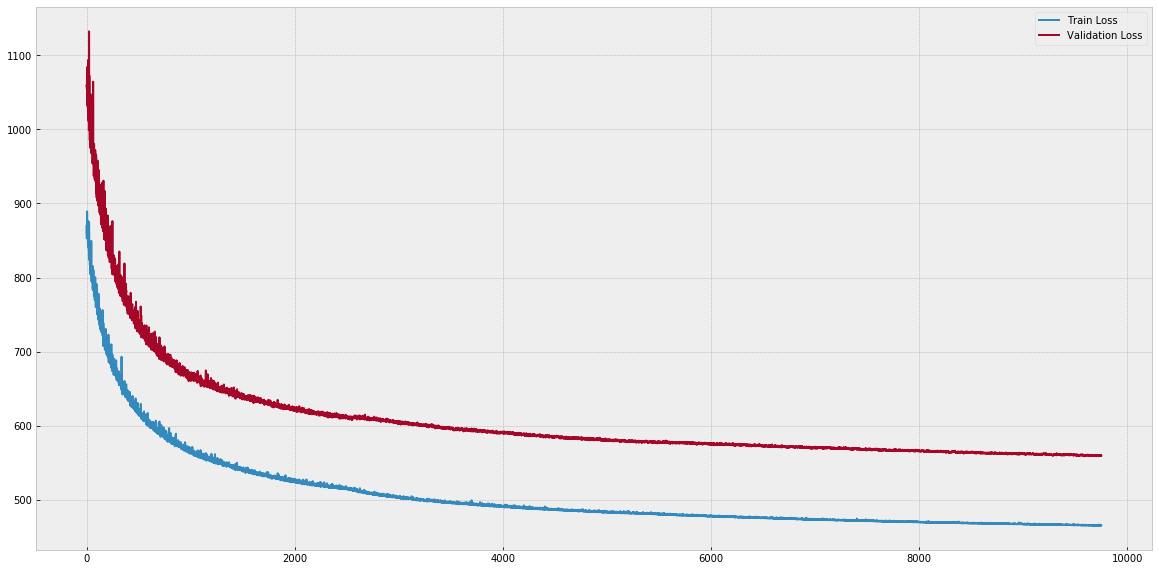

In [28]:
# Plot the train/validation loss values
plt.figure(figsize=(20,10))
_loss = history.history['loss'][250:]
_val_loss = history.history['val_loss'][250:]
train_loss_plot, = plt.plot(range(1, len(_loss)+1), _loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(_val_loss)+1), _val_loss, label='Validation Loss')
_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

In [29]:
# How good are the model’s predictions

df = y_val.copy()
# Add a column for the model's predicted values
df['pred'] = model.predict([X_val_continuous, X_val_categorical['area_mapping']])
# Calculate the difference between the predicted and the actual price
df['diff'] = df['pred'] - df['price']
# Calculate the absolute difference between the predicted and the actual price
df['abs_diff'] = np.abs(df['diff'])
# Calculate the percentage of the difference from the actual price
df['%diff'] = 100 * (df['diff'] / df['price'])
# Calculate the absolute percentage difference from the actual price
df['abs_%diff'] = np.abs(df['%diff'])

In [30]:
# What is the biggest difference in absolute values?
# Sort by the 'abs_diff' field and show the 5 largest mistakes in absolute values
df.sort_values("abs_diff", ascending=False).head(5)

,price,pred,diff,abs_diff,%diff,abs_%diff
223,412600.0,412720.781250,120.781250,120.781250,0.029273,0.029273
133,412600.0,412720.781250,120.781250,120.781250,0.029273,0.029273
137,203680.0,203792.875000,112.875000,112.875000,0.055418,0.055418
35,207590.0,207489.453125,-100.546875,100.546875,-0.048435,0.048435
65,207590.0,207489.453125,-100.546875,100.546875,-0.048435,0.048435


In [31]:
# Calculate the mean and std. of the diff field
diff_mean, diff_std = df['diff'].mean(), df['diff'].std()
print("The mean is very close to 0 ({mean}) with std. {std}.".format(mean=round(diff_mean, 2),
                                                                     std=round(diff_std, 2)))

The mean is very close to 0 (-0.51) with std. 23.7.


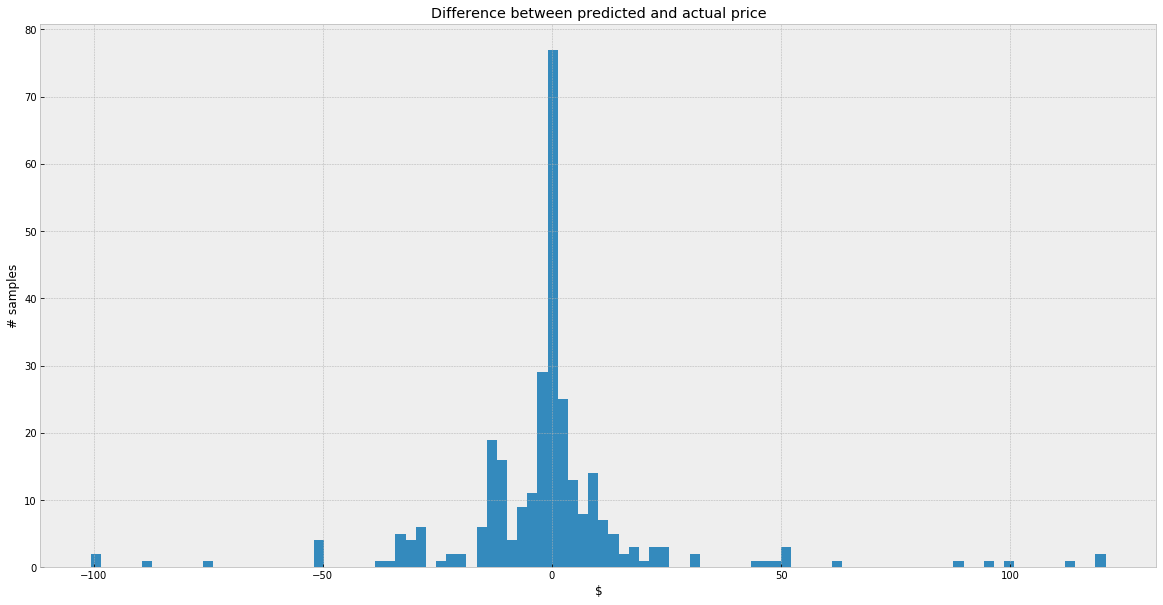

In [32]:
# Histogram of the differences
plt.figure(figsize=(20,10))
plt.hist(df['diff'], bins=100)
plt.xlabel("$")
plt.ylabel("# samples")
_ = plt.title("Difference between predicted and actual price")